In [1]:
import jax
import jax.numpy as jnp 
import flax.linen as nn
import optax
from flax.training.train_state import TrainState

# Fixed Point Iteration as a Layer
Solving the following problem:

$$
z = tanh(W*z + x)
$$

This implicit layer can be represented as a fixed point iteration. 

In [2]:

class TanhFiexedPointLayer(nn.Module):
    out_features: int 
    tol: float = 1e-04 
    max_iter: int = 50 

    @nn.compact
    def __call__(self, x):
        z = jnp.zeros_like(x)
        iter = 0
        linear = nn.Dense(self.out_features, use_bias=False)
        # iterate until convergence
        while iter < self.max_iter:
            z_next = nn.tanh(linear(x) + z)
            error = jnp.linalg.norm(z_next - z)
            z = z_next
            iter += 1  
            if error < self.tol:
                break

        return z, iter, error

In [3]:
layer = TanhFiexedPointLayer(50)
key = jax.random.PRNGKey(1)

x = jax.random.normal(key, (10, 50))

# initialize the parameters
init_params = layer.init(key, jnp.ones((10, 50)))
print(init_params)
# apply the layer
z, iter, err = layer.apply(init_params, x)
z.shape, iter, err

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


FrozenDict({
    params: {
        Dense_0: {
            kernel: Array([[-0.00112402,  0.01049197, -0.1107769 , ...,  0.06686379,
                     0.06641757,  0.15790488],
                   [-0.05339506,  0.17241323, -0.22775021, ..., -0.22635862,
                     0.07368673, -0.18832724],
                   [ 0.16974592, -0.04329657,  0.19627635, ..., -0.03350458,
                    -0.02757894,  0.09015729],
                   ...,
                   [ 0.02844509,  0.22286433,  0.16291836, ...,  0.0094636 ,
                     0.02387309, -0.01765661],
                   [-0.05769478, -0.18182161, -0.02211224, ...,  0.06700245,
                     0.0289749 , -0.1785477 ],
                   [ 0.02784303,  0.05188631,  0.01045604, ..., -0.18541177,
                     0.09383972, -0.3002459 ]], dtype=float32),
        },
    },
})


((10, 50), 50, Array(0.00084512, dtype=float32))

# Differentiation of ODE

In [4]:
from jax.experimental.ode import odeint
from functools import partial


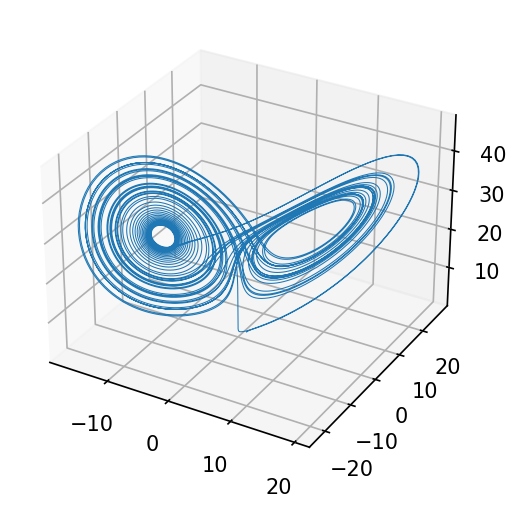

In [5]:
def f(state, t, rho, sigma, beta):
    x, y, z = state 
    return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

f = partial(f, rho=28.0, sigma=10.0, beta=8.0/3.0)
t = jnp.linspace(0, 50, 10000)
state0 = jnp.array([1.0, 1.0, 1.0])

ys = odeint(f, state0, t)

import matplotlib.pyplot as plt

def plot_3d_path(ax, ys, color):
  x0, x1, x2 = ys.T
  ax.plot(x0, x1, x2, lw=0.5, color=color)

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(111, projection='3d')
plot_3d_path(ax, ys, color='C0')

Use the dynamical system to generate training data

In [6]:
train = ys

In [7]:
# create a neural dynamical model

class NeuralDynamics(nn.Module):
    num_states: int = 3

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(3)(x)
        x = nn.relu(x)
        #x = nn.Dense(16)(x)
        #x = nn.relu(x)
        x = nn.Dense(self.num_states)(x)

        return x

dynamics = NeuralDynamics()
key = jax.random.PRNGKey(0)

param_init = dynamics.init(key, jnp.hstack([state0, 0]))

def f(x, t, params):

    return dynamics.apply(params, jnp.hstack([x,t])) 


print(f(state0, 0, param_init))

y = odeint(f, state0, t, param_init)



[0. 0. 0.]


In [8]:
optimizer = optax.chain(
    #optax.clip_by_global_norm(1.0),
    optax.clip(0.01),
    #optax.scale(1.2),
    #optax.lamb(1e-04),
    optax.adam(1e-2)
)

train_state = TrainState.create(
    apply_fn=f, # not used
    params=param_init,
    tx = optimizer,
)

#@jax.jit
def train_step(f, state_init, t, target, train_state):
    def mse_loss(params):
        # prediction
        outputs_pred = odeint(f, state_init, t, params)
        #outputs_pred = jnp.clip(outputs_pred, 16., 40.)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        return pred_loss
    
    loss, grad = jax.value_and_grad(mse_loss)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state

# train the model
for i in range(400):
    loss, grad, train_state = train_step(f, state0, t, ys, train_state)
    print(loss)

282.46603
267.98227
255.80333
245.50926
237.12247
233.04254
229.9437
226.74875
223.50197
220.21657
216.8914
213.53783
210.1722
206.81267
203.47699
200.18204
196.94328
193.77464
190.6886
187.68704
184.76553
181.92413
179.16582
176.4953
173.91833
171.4411
169.06993
166.80304
164.63629
162.55453
160.53589
158.56837
156.6471
154.77214
152.94077
151.14996
149.40134
147.69952
146.0511
144.464
142.9425
141.48805
140.10452
138.78543
137.5232
136.31131
135.14546
134.02592
132.95624
131.94023
130.98033
130.08134
129.24715
128.47435
127.757286
127.09199
126.464325
126.22391
125.96342
125.254776
124.43818
123.985054
123.748886
123.339905
123.0325
122.8162
122.54503
122.24313
121.9962
121.75595
121.47782
121.2367
121.00296
120.7246
120.447296
120.19143
119.89313
119.58874
119.32363
119.01879
118.623924
118.18069
117.74552
117.27926
116.714584
116.10187
115.414444
114.59483
113.63295
112.51577
111.31742
110.27952
109.815506
109.68857
109.61631
110.23587
110.20413
109.268265
109.357635
109.30138
109.

In [9]:
outputs_pred = odeint(f, state0, t, train_state.params)
outputs_pred

Array([[ 1.       ,  1.       ,  1.       ],
       [ 1.0002636,  0.9998908,  1.0052977],
       [ 1.0005273,  0.9997816,  1.0105963],
       ...,
       [-2.6455886, -6.9923463, 24.85399  ],
       [-2.6459582, -6.99345  , 24.855076 ],
       [-2.6463277, -6.994554 , 24.85616  ]], dtype=float32)

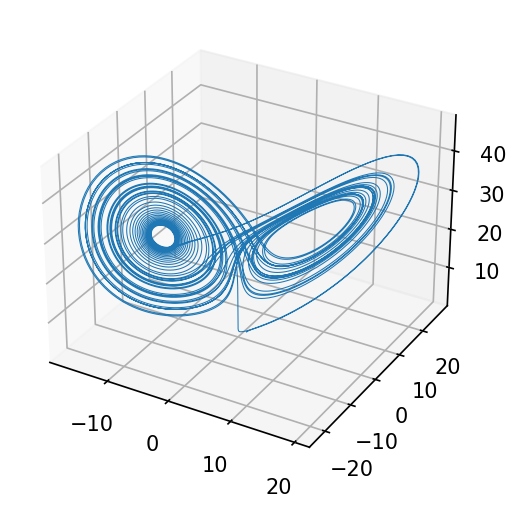

In [10]:
y_preds = odeint(f, state0, t, train_state.params)

# Plot resulting model.
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(111, projection='3d')
plot_3d_path(ax, ys, color='C0')


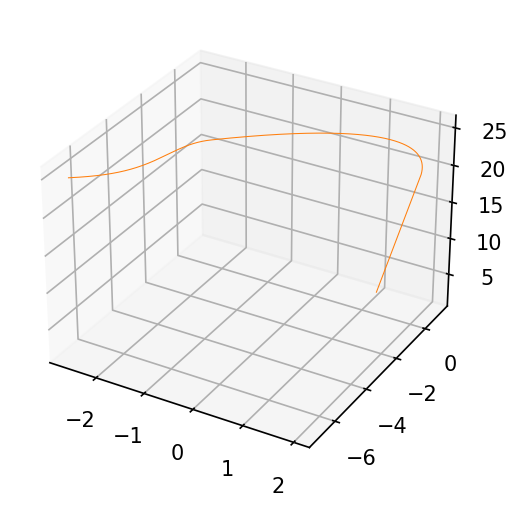

In [11]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(111, projection='3d')
plot_3d_path(ax, y_preds, color='C1')